# Para aumentar o display do Pandas

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 3554)

# Para resetar todas as configurações do Pandas:

In [ ]:
import pandas as pd
pd.reset_option('all')

#  Análise de dados Nashira

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from IPython.display import Image
from rocketpy import Environment, SolidMotor, Rocket, Flight
import datetime

### Transformando CSV em dataframe

In [ ]:
df = pd.read_csv("nashira_telemetry.csv", decimal = ",")
timestamp = df.columns[0] #primeira coluna
df.set_index(timestamp) #indexamos para realizar buscas
df.columns = [x.lower() for x in df.columns] #formata todas as colunas para minúsculo
df

df.head()

### Removendo colunas vazias

- As colunas de validação (imu_valid, ekf_valid, etc) não tem nenhum dado em todo o CSV por isso serão droppadas

In [ ]:
colunas_para_checar = df.columns[32:37] #vamos ver se as colunas da 32 à 37 estão totalmente vazias
for col in colunas_para_checar:
    if df[col].isna().all():
        df = df.drop(columns=col,axis= "columns") #se estiverem vazias droppa as colunas

df.head()

### Checagem do GPS

- Para simplificar vou criar uma coluna auxiliar à gnss_fix, onde ela indicará apenas se há sinal de gps (1) ou se não há (0)

In [ ]:
df['gps_available'] = df['gnss_fix'] > 0

### Formatação dos timestamps

- Para simplificar a leitura vamos usar o intervalo de tempo do lançamento ao invés das timestamps nos gráficos

In [ ]:
df['time_interval'] = df['timestamp_ms'] - df['timestamp_ms'][0]

In [ ]:
df.tail()

### Análise da altitude

- Temos os dados da altitude do GPS e a do Barômetro. Vamos plottar ambos e identificar se há inconsistência na medição de alguma
- Vamos usar também os dados de pressão para ver se há alguma discrepância de cálculo

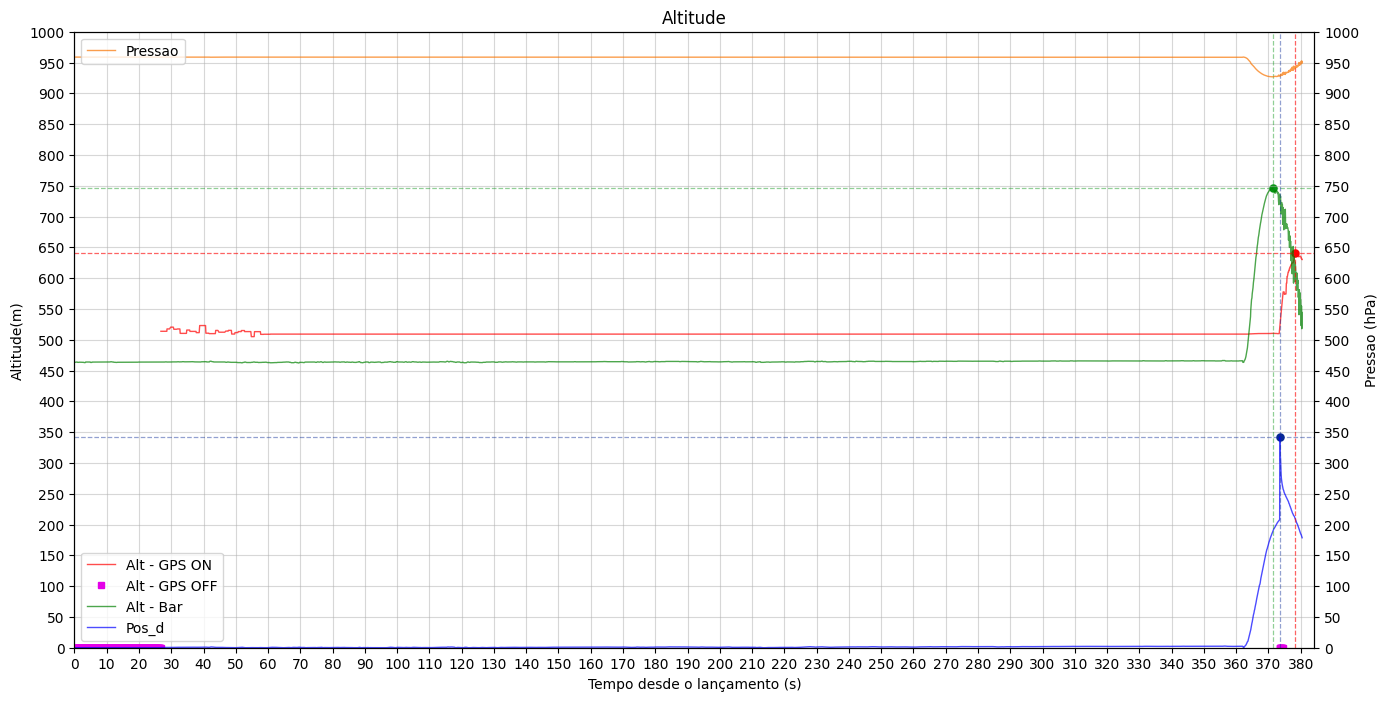

Altitude Apogeu GPS (ASL): 640.3m
Tempo Apogeu GPS: 378.304s
Altitude Apogeu BAR (ASL): 746.2m
Tempo Apogeu BAR: 371.392s


In [45]:
df_alt = df[["time_interval", "alt_gps", "alt_bar", "pressure", "gps_available", "pos_d"]].copy()
df_alt["time_interval"] = (df_alt["time_interval"]/1000)
df_alt["pos_d"] = abs(df_alt["pos_d"])

df_gps_on = df_alt[df_alt["gps_available"] == 1]
df_gps_off = df_alt[df_alt["gps_available"] == 0]

#Valores máximos dos eixos
max_x = df_alt["time_interval"].max()

#Criando o eixo x (tempo)
figure, axe1 = plt.subplots(figsize=(16,8))
axe1.set_xlabel("Tempo desde o lançamento (s)")
axe1.set_xlim(-0.01,1.01*max_x)
axe1.xaxis.set_major_locator(ticker.MaxNLocator(40))

#Criando o primeiro eixo y (altitude)
axe1.plot(df_gps_on["time_interval"], df_gps_on["alt_gps"], color ="r", linestyle="-",label ="Alt - GPS ON ", alpha = 0.7, linewidth = 1)
axe1.plot(df_gps_off["time_interval"], df_gps_off["alt_gps"], 's',  color ="#E400E8", label="Alt - GPS OFF", markersize=4, alpha= 1)
axe1.plot(df_alt["time_interval"],df_alt["alt_bar"], color ="g", linestyle="-",label ="Alt - Bar", alpha = 0.7, linewidth = 1)
axe1.plot(df_alt["time_interval"],df_alt["pos_d"], color="b", linestyle="-", label="Pos_d", alpha=0.7, linewidth=1)

axe1.set_ylabel("Altitude(m)")
axe1.set_ylim(-0.01,1000)
axe1.grid(True, alpha=0.5)
axe1.legend(loc= "lower left")
axe1.yaxis.set_major_locator(ticker.MaxNLocator(22))

#Marcando o apogeu
df_apogeu = (df[["timestamp_ms","time_interval","alt_gps","alt_bar","pos_d"]]).copy() #Usamos o dataframe completo para determinar o apogeu
df_apogeu["pos_d"] = abs(df_apogeu["pos_d"]) #precisamos usar o módulo aqui também

alt_ap_gps = df_apogeu["alt_gps"].max() #em metros
alt_ap_bar = df_apogeu["alt_bar"].max()
alt_ap_posd = df_apogeu["pos_d"].max()

id_apogeu_gps = df_apogeu["alt_gps"].idxmax()
id_apogeu_bar = df_apogeu["alt_bar"].idxmax()
id_apogeu_posd = df_apogeu["pos_d"].idxmax()

timestamp_ap_gps = df_apogeu["timestamp_ms"].iloc[id_apogeu_gps] #em ms
timestamp_ap_bar = df_apogeu["timestamp_ms"].iloc[id_apogeu_bar]
timestamp_ap_posd = df_apogeu["timestamp_ms"].iloc[id_apogeu_posd]

time_interval_ap_gps = df_apogeu["time_interval"].iloc[id_apogeu_gps] #em ms
time_interval_ap_bar = df_apogeu["time_interval"].iloc[id_apogeu_bar]
time_interval_ap_posd = df_apogeu["time_interval"].iloc[id_apogeu_posd]

time_interval_ap_gps /= 1000
time_interval_ap_bar /= 1000
time_interval_ap_posd /= 1000

axe1.axvline(x=time_interval_ap_gps, color="#FD00009C", linewidth = 0.9, linestyle = "--")
axe1.axhline(y=alt_ap_gps, color="#FD00009C", linewidth = 0.9, linestyle = "--")
axe1.scatter(x=time_interval_ap_gps, y=alt_ap_gps, color="#FD00009C", linewidths= 0.1, alpha=1, label = "Apogeu - GPS")
axe1.axvline(x=time_interval_ap_bar, color="#07941371", linewidth = 0.9, linestyle = "--")
axe1.axhline(y=alt_ap_bar, color="#07941371", linewidth = 0.9, linestyle = "--")
axe1.scatter(x=time_interval_ap_bar, y=alt_ap_bar, color="#07941371", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")
axe1.axvline(x=time_interval_ap_posd, color="#07289470", linewidth = 0.9, linestyle = "--")
axe1.axhline(y=alt_ap_posd, color="#07289470", linewidth = 0.9, linestyle = "--")
axe1.scatter(x=time_interval_ap_posd, y=alt_ap_posd, color="#07289470", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")



#Criando o segundo eixo y (pressao)
axe2 = axe1.twinx()
axe2.plot(df_alt["time_interval"],df_alt["pressure"], color ="#F97400FF", linestyle="-",label ="Pressao", alpha = 0.7, linewidth = 1)
axe2.set_ylabel("Pressao (hPa)")
axe2.set_ylim(-0.01,1000)
axe2.grid(False)
axe2.legend(loc = "upper left")
axe2.yaxis.set_major_locator(ticker.MaxNLocator(22))


plt.title("Altitude")
plt.show()
print(f"Altitude Apogeu GPS (ASL): {alt_ap_gps}m")
print(f"Tempo Apogeu GPS: {time_interval_ap_gps}s")
print(f"Altitude Apogeu BAR (ASL): {alt_ap_bar}m")
print(f"Tempo Apogeu BAR: {time_interval_ap_bar}s")

- Agora, iremos separar os plots com base no flight state e considerar o TEMPO DECORRIDO e a ALTITUDE GANHA desde o ínicio do STATE, para podermos analisar a variação da altitude em função do tempo

- Atenção!!!
Os dados de GPS e BARÔMETRO são dados num formato "above sea level" enquanto os dados de POS_D são "above ground level" (AGL)

In [ ]:
states = df["flight_state"].unique()
n_states = len(states) #sabemos que temos 4 flight_states [1,2,3,5]

figure, axes = plt.subplots(n_states,3, figsize=(32,4*n_states)) #Teremos 2 gráficos (GPS e BAR) por "linha", cada linha representa 1 state

for i, state in enumerate(states):
    df_state = df[df["flight_state"] == state].copy() #Copiamos só o flight state atual
    df_state["time_interval"] = (df_state["time_interval"]/1000)
    df_state["pos_d"] = abs(df_state["pos_d"]) #pos_d é um valor relativo, então não precisa da parte negativa
    print(f"State: {state}")
    print(f"t0: {df_state["time_interval"].min()}s")
    print(f"tf: {df_state["time_interval"].max()}s")

    #Se não houver nada no state pula ele
    if len(df_state) == 0:
        continue
    
    #Cria um df para pontos com e sem sinal de GPS
    df_gps_on_state = df_state[df_state["gps_available"] == 1] #Pontos em que já sinal de GPS
    df_gps_off_state = df_state[df_state["gps_available"] == 0]#Pontos em que não há sinal de GPS

    #Checamos se não há duplicatas
    n_total = len(df_state)
    n_filtros = len(df_gps_on_state) + len(df_gps_off_state)
    if n_filtros != n_total:
        print(f"Erro no state {state}: soma dos filtros ({n_filtros}) não bate com total! ({n_total})")

    #Ordenamos os df por tempo
    df_gps_on_state = df_gps_on_state.sort_values("time_interval")
    df_gps_off_state = df_gps_off_state.sort_values("time_interval")

    #Coluna 1 - GPS
    if len(df_gps_on_state) > 0: #Para os pontos com sinal de GPS
        axes[i,0].plot(df_gps_on_state["time_interval"], df_gps_on_state["alt_gps"], color ="r", linestyle="-",label ="GPS ON", alpha = 0.7, linewidth = 2)

    if len(df_gps_off_state) > 0: #Para os pontos sem sinal de GPS
        axes[i,0].plot(df_gps_off_state["time_interval"], df_gps_off_state["alt_gps"], 's',  color ="#E400E8", label="GPS OFF", markersize=3, alpha= 1)

    #Marcando o apogeu
    df_apogeu = (df[["timestamp_ms","time_interval","alt_gps","alt_bar","pos_d"]]).copy() #Usamos o dataframe completo para determinar o apogeu
    df_apogeu["pos_d"] = abs(df_apogeu["pos_d"]) #precisamos usar o módulo aqui também

    alt_ap_gps = df_apogeu["alt_gps"].max() #em metros
    alt_ap_bar = df_apogeu["alt_bar"].max()
    alt_ap_posd = df_apogeu["pos_d"].max()

    id_apogeu_gps = df_apogeu["alt_gps"].idxmax()
    id_apogeu_bar = df_apogeu["alt_bar"].idxmax()
    id_apogeu_posd = df_apogeu["pos_d"].idxmax()


    timestamp_ap_gps = df_apogeu["timestamp_ms"].iloc[id_apogeu_gps] #em ms
    timestamp_ap_bar = df_apogeu["timestamp_ms"].iloc[id_apogeu_bar]
    timestamp_ap_posd = df_apogeu["timestamp_ms"].iloc[id_apogeu_posd]

    time_interval_ap_gps = df_apogeu["time_interval"].iloc[id_apogeu_gps] #em ms
    time_interval_ap_bar = df_apogeu["time_interval"].iloc[id_apogeu_bar]
    time_interval_ap_posd = df_apogeu["time_interval"].iloc[id_apogeu_posd]

    time_interval_ap_gps /= 1000
    time_interval_ap_bar /= 1000
    time_interval_ap_posd /= 1000

    axes[i,0].axvline(x=time_interval_ap_gps, color="#FD00009C", linewidth = 0.9, linestyle = "--")
    axes[i,0].axhline(y=alt_ap_gps, color="#FD00009C", linewidth = 0.9, linestyle = "--")
    axes[i,0].scatter(x=time_interval_ap_gps, y=alt_ap_gps,  color="#FD00009C", linewidths= 0.1, alpha=1, label = "Apogeu - GPS")


    #Detalhes - Coluna 1
    axes[i,0].set_title(f"Altitude GPS - Flight State {state}", fontsize = 14)
    axes[i,0].set_xlabel('Tempo desde o lancamento (s)', fontsize = 12)
    axes[i,0].set_ylabel('Altitude(m)', fontsize = 12)
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.5)

    #Ajusta o eixo x
    time_min = (df_state["time_interval"].min())
    time_max = (df_state["time_interval"].max())

    print(f"time_min: {time_min}s")
    print(f"time_max: {time_max}s")

    axes[i,0].set_xlim(time_min,time_max)
    axes[i,0].xaxis.set_major_locator(ticker.MaxNLocator(16))

    #Ajusta o eixo y
    alt_min = min(df_state["alt_gps"].min(), df_state["alt_bar"].min(), df_state["pos_d"].min())
    alt_max = max(df_state["alt_gps"].max(), df_state["alt_bar"].max(), df_state["pos_d"].max())

    print(f"duracao: {round(time_max-time_min,2)}s")
    print("-------------------------------------")

    axes[i,0].set_ylim(0.95*alt_min,1.05*alt_max)
    axes[i,0].yaxis.set_major_locator(ticker.MaxNLocator(25))

    #Coluna 2 - BAR
    axes[i,1].plot(df_state["time_interval"], df_state["alt_bar"], color ="g", linestyle="-",label ="BAR", alpha = 0.7, linewidth = 2)

    #Marcando o apogeu
    axes[i,1].axvline(x=time_interval_ap_bar, color="#07941371", linewidth = 0.9, linestyle = "--")
    axes[i,1].axhline(y=alt_ap_bar, color="#07941371", linewidth = 0.9, linestyle = "--")
    axes[i,1].scatter(x=time_interval_ap_bar, y=alt_ap_bar, color="#07941371", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")

    #Detalhes - Coluna 2
    axes[i,1].set_title(f"Altitude Barométrica - Flight State {state}", fontsize = 14)
    axes[i,1].set_xlabel('Tempo desde o lancamento (s)', fontsize = 12)
    axes[i,1].set_ylabel('Altitude(m)', fontsize = 12)
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.5)

    #Ajusta o eixo x
    axes[i,1].set_xlim(time_min,time_max)
    axes[i,1].xaxis.set_major_locator(ticker.MaxNLocator(16))

    #Ajusta o eixo y
    axes[i,1].set_ylim(0.95*alt_min,1.05*alt_max)
    axes[i,1].yaxis.set_major_locator(ticker.MaxNLocator(25))


    #Coluna 3 - pos_d (altitude)
    axes[i,2].plot(df_state["time_interval"], df_state["pos_d"], color ="b", linestyle="-",label ="pos_d", alpha = 0.7, linewidth = 2)

    #Marcando o apogeu
    axes[i,2].axvline(x=time_interval_ap_posd, color="#07289470", linewidth = 0.9, linestyle = "--")
    axes[i,2].axhline(y=alt_ap_posd, color="#07289470", linewidth = 0.9, linestyle = "--")
    axes[i,2].scatter(x=time_interval_ap_posd, y=alt_ap_posd, color="#07289470", linewidths= 0.1, alpha=1, label = "Apogeu - BAR")

    #Detalhes - Coluna 3
    axes[i,2].set_title(f"Pos_D (vertical) - Flight State {state}", fontsize = 14)
    axes[i,2].set_xlabel('Tempo desde o lancamento (s)', fontsize = 12)
    axes[i,2].set_ylabel('Altitude(m)', fontsize = 12)
    axes[i,2].legend()
    axes[i,2].grid(True, alpha=0.5)

    #Ajusta o eixo x
    axes[i,2].set_xlim(time_min,time_max)
    axes[i,2].xaxis.set_major_locator(ticker.MaxNLocator(16))

    #Ajusta o eixo y
    axes[i,2].set_ylim(0.95*alt_min,1.05*alt_max)
    axes[i,2].yaxis.set_major_locator(ticker.MaxNLocator(25))

print(f"apogeu_gps (ASL): {alt_ap_gps}m")
print(f"apogeu_gps_time: {time_interval_ap_gps}s")
print(f"apogeu_bar (ASL): {alt_ap_bar}m")
print(f"apogeu_bar_time: {time_interval_ap_bar}s")
print(f"apogeu_pos_d (AGL): {alt_ap_posd}m")
print(f"apogeu_pos_d_time: {time_interval_ap_posd}s")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

### Pontos de destaque
- Note que houve uma perda de conexão com o GNSS na fase 5
- É preciso tratar os ruídos que estão distorcendo o eixo Y na fase 1 e 5 (sugestão de usar Savitzky-Golay)


*Analisando discrepâncias das medidas do GPS e BAR

- Vamos plottar um gráfico do "offset" entre as medidas do GPS e do Barômetro

In [ ]:
df_offset = df[(["time_interval","alt_gps", "alt_bar", "gps_available"])].copy()

#Calculo o OFFSET de cada medição
df_offset[["alt_gps", "alt_bar"]] = df_offset[["alt_gps", "alt_bar"]].astype("float32")
df_offset["offset"] = (abs(df_offset["alt_bar"] - df_offset["alt_gps"]))

#Deixa o tempo em segundos
df_offset["time_interval"] = df_offset["time_interval"]/1000

plt.figure(figsize=(14,6))

#Cria um df para pontos com e sem sinal de GPS
df_gps_on = (df_offset[df_offset["gps_available"] == 1])
df_gps_off = (df_offset[df_offset["gps_available"] == 0])

#Checa se não há duplicatas
n_total = len(df_offset)
n_filtros = len(df_gps_off) + len(df_gps_on)
if n_filtros != n_total:
    print(f"Erro no state {state}: soma dos filtros ({n_filtros}) não bate com total! ({n_total})")

#Plot do Offset
plt.plot(df_gps_on["time_interval"], df_gps_on["offset"],color ="r", linestyle="-", linewidth = 1, label = "GPS ON") 

#Plot dos pontos com GPS off
plt.plot(df_gps_off["time_interval"], df_gps_off["offset"], 's',  color ="#E400E8", label="GPS OFF", markersize=1, alpha= 1)


#Ajusta o eixo x
plt.xlim(-0.01*df_offset["time_interval"].min(), 1.01*df_offset["time_interval"].max())
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(20)) #O num de valores nos eixos foi decidido de forma à deixarclaro identificação do valor mais alto nele

#Ajusta o eixo y
plt.ylim(-0.01*df_offset["offset"].min(), 1.01*df_offset["offset"].max())
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(46))


plt.title("Offset GPS-BAR")
plt.xlabel("Tempo desde o lançamento (s)")
plt.ylabel("Offset (m)")

plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

Note que o OFFSET tem um comportamento constante (ideal) em boa parte do tempo em que o GPS funciona - isso indica que nossas medições de altitude por bar e pelo GPS podem ser usadas em conjunto para estimar dados quando o offset é considerado

Além disso, note que por volta dos ~365s temos uma região de alta incerteza. Nesse intervalo o GPS perde sinal e há uma queda abrupta de pressão, o que torna difícil concluir se o gps ou o barômetro apresentam medições confiáveis

Após o GPS recuperar o sinal o offset continua aumentando - Análise alt_gps x alt_bar x pressure (Não dá muita informação) -> Entender quando o foguete começa a perder velocidade pode ser a chave para determinar esse comportamento

-MARCAR NOS GRÁFICOS: APOGEU (MAIOR ALTITUDE), BURNOUT(ACCEL = 0, VEL CAI, FLIGHT_STATE MUDA), LANDING(ALTITUDE RELATIVA PROX À 0)

# Condições base da competição
A princípio precisamos estabelecer as condições base às quais o foguete estava submetido durante a coleta de dados


### 1) Environment
-Sabemos que a data de lançamento do foguete foi:

    Data: 08/11/2025

-Analisando a 6th Space Challenge, sabemos que para esse ano o local de lançamento foi num novo lugar, o "Sugarcane Launch Range" em "Lacanga - SP", obtendo as coordenadas pelo Google Maps temos:

    Latitude: -21.938700249834092
   
    Longitude: -48.950450497781446

- Para a altitude foi utilizado o site https://contourmapcreator.urgr8.ch/ para extrair o mapa topográfico da região.
A área selecionada foi um quadrado com as extremidades (latitude, longitude):
Vértice Superior-Esquerdo: -21.937621811402707, -48.951870203018196
Vértice Inferior-Direita:-21.940040120354265, -48.94905924797059

Foi obitido a altitude média de 490m na região de lançamento em relação ao nível do mar

Porém, para manter a consistência com os dados coletados, será utilizada a faixa de altitude coletada pelo GPS do NASHIRA, sendo essa:

    Altitude mínima: 505.0m
    Altitude máxima: 640.3m
    

In [ ]:
Image(filename="Environment\Mapa topológico - Sugarcane Launch Range - Lacanga - SP.png", width= 700)

In [ ]:
#Retirando os valores de 0 medidos pelo GPS (GPS desligado)
df1 = df.copy()
df1["alt_gps"] = df1["alt_gps"].replace(0,np.nan) 
df1["alt_gps"].dropna
print(f"Altitude mínima: {df1["alt_gps"].min()}")
print(f"Altitude máxima: {df1["alt_gps"].max()}")

- Para a pressão usaremos os dados do NASHIRA:

In [ ]:
print(f"Pressão minima: {df["pressure"].min()}")
print(f"Pressão máxima: {df["pressure"].max()}")

- Para criar o environment foi utilizado uma reanalysis ERA5 feita pela ECMWF.

- A reanalisys utilizada pode ser encontrada no link: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=download

- Foram utilizados os seguintes critérios:

Variable: Geopotential, Temperature, U-component of wind, V-component of wind

Data: 08/11/2025, 12:00

Pressure level: 925hPa - 975hPa

North:    -21.80

West:     -49.10

South:    -22.10

East:     -48.80


In [ ]:
env = Environment(latitude=-21.938700249834092, longitude=-48.950450497781446, elevation=505)
launch_day = datetime.datetime(2025,11,8,12,0,0)
filename = "Environment\EuroC pressure reanalysis - 2025 08 11.nc"

print(f"data de lançamento {launch_day}")
env.set_date((launch_day.year, launch_day.month, launch_day.day, launch_day.hour))
print(launch_day.year)
print(launch_day.month)
print(launch_day.day)
print(launch_day.hour)
env.set_atmospheric_model(
    type="reanalysis",
    file=filename,
    dictionary="ECMWF"
)

env.plots.atmospheric_model()

In [ ]:
env.info()

### 2) Motor

Na categoria de 500m da LASC competem apenas foguetes com combustível sólido, então como foi indicado usaremos o Calisto como base.

Todas as informações do calisto foram utilizadas no passo-a-passo a seguir: https://docs.rocketpy.org/en/latest/user/first_simulation.html

Assim, as coordenadas utilizadas tem o mesmo ponto de referência.

    -Motor: Cesaroni_M1670

https://github.com/RocketPy-Team/RocketPy/blob/master/data/motors/cesaroni/Cesaroni_M1670.eng

In [ ]:
Pro75M1670 = SolidMotor(
    thrust_source="Motor/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

In [ ]:
Pro75M1670.info()

### 3) Rocket
Seguiremos usando o Calisto como base

É importante salientar o que cada característica passada indica:

    -Radius: Raio do foguete
    -Mass: Massa sem o motor (kg)
    -Inertia: Tupla (i1,i2,i3) da inércia em relação ao centro de massa sem o motor. i1 e i2 são a inércia em relação aos eixos perpendiculares ao foguete e i3 ao eixo paralelo/central do foguete
    -Power_off_drag: Drag curve em csv do motor desligado
    -Power_on_drag: Drag curve em csv do motor ligado (se não tiver pode usar do desligado assumindo possíveis imprecisões na simulação)
    -Center_of_mass_without_a_motor: Coordendas do centro de massa sem o motor
    -Coordinate_system_orientation: Orientação do sistema de coordenadas
*É possível passar a inércia com cada componente dos tensores checar https://docs.rocketpy.org/en/latest/user/rocket/rocket_usage.html#rocketusage para mais info

In [ ]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="Rocket/calisto/powerOffDragCurve.csv",
    power_on_drag="Rocket/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

- Adicionando o motor

In [ ]:
calisto.add_motor(Pro75M1670, position=-1.255)

- Adicionando componentes aerodinâmicos

Usamos um cone de ponta, 4 barbatanas e 1 cauda

In [ ]:
nose_cone = calisto.add_nose(
    length=0.55829, kind="von karman", position=1.278
)

fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("Fins/NACA0012-radians.txt","radians"),
)

tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

- Checando a estabilidade

Valores muito altos ou negativos de Static Margin indicam um foguete com estabilidade inedequada, o que gerará inconsistência na simulação

In [ ]:
calisto.plots.static_margin()

- Checando se os componentes foram acoplados de maneira correta

In [ ]:
calisto.draw()

- Simulando o vôo

O regulamento da LASC estipula: 

    Inclinação de lançamento: 80°+/- 5°
    Tamanho dos trilhos: 4m

In [ ]:
Image(filename="Imagens complementares/Inclinação dos trilhos.png")

In [ ]:
Image(filename="Imagens complementares/Tamanho dos trilhos.png")

In [ ]:
simulacao = Flight(
    rocket = calisto,
    environment= env,
    rail_length=4.0,
    inclination= 80,
    heading= 0 #direção horizontal final do voo (Norte = 0, Leste = 90,...)
)

In [ ]:
simulacao.plots.trajectory_3d() #projeção em 3d

simulacao.plots.linear_kinematics_data()

In [ ]:
simulacao.info()